# AMPA

## Model overview

AMPA receptor is an ionotropic receptor of neurotransmitter `Glutamate`. After being bound by Glutamate, it opens the sodium and potassium ion channels and induce postsynaptic current.

AMPA receptor plays important role in long-term potentiation.

This synapse model describes the transmitter-activated ion channel as synaptic conductance $g_{syn}(t)$.

## Implementation (scaler)

Our implementation is based on BrainPy framework.

In [1]:
import brainpy as bp
from brainpy import numpy as np

We will implement two types of AMPA model. `AMPA 1` is a simple model with one exponential decay, and `AMPA 2` is a HH-like model.

### AMPA 1

Let's first take a look at a simple model with only one exponential decay.

Synaptic conductance $g_{syn}$ is given by:

$$g_{syn} = \bar{g}_{syn} s $$

where $\bar{g}_{syn}$ is the maximum synaptic conductance. 

The gating variable $s$ represents the fraction of open synaptical channel. It's dynamic is given by:

$$\frac{d s}{d t}=-\frac{s}{\tau_{decay}}+\sum_{k} \delta(t-t_{j}^{k})$$

where $\tau_{decay}$ is around 2 to 5 ms.

Here we will implement the dynamics of $g_{syn}$ with a `update()` function.

The synaptic current $I_{syn}$ represents the current that passes through a synaptic channel, which is given by: 

$$I_{syn}= g_{syn} (V-E_{syn})$$

where $V$ is the membrane potential of the post-synaptic neuron (where the receptors and ion channels located in), and the reversal potential $E_{syn}$ for AMPA receptor is $0$.

We will implement the delay of the synapse (from synapse to post-synaptic) by using the decorator `@bp.delayed` before the `output` function which updating the synaptic current.

Post-synaptic input current will be the sum of synaptic current from all channels.

In [2]:
E_SYN = 0.
TAU = 2.
G_MAX = .10

def AMPA1(g_max=G_MAX, E=E_SYN, tau_decay=TAU):
    """AMPA conductance-based synapse (type 1).

    Parameters
    ----------
    g_max : float
        Maximum conductance.
    E : float
        Reversal potential.
    tau_decay : float
        Tau for decay.
    """

    requires = dict(
        ST=bp.types.SynState(['s'], help='AMPA synapse state.'),
        pre=bp.types.NeuState(['sp'], help='Pre-synaptic neuron state must have "sp" item.'),
        post=bp.types.NeuState(['V', 'inp'], help='Pre-synaptic neuron state must have "V" and "inp" item.'),
    )

    # dynamics of gating variable
    @bp.integrate
    def ints(s, t):
        return - s / tau_decay

    # dynamics of synaptic conductance
    def update(ST, _t_, pre, post):
        s = ints(ST['s'], _t_)
        if pre['sp'] == True:
            s += 1
        ST['s'] = s     

    # synaptic current
    @bp.delayed
    def output(ST, post):
        I_syn = - g_max * ST['s'] * (post['V'] - E)
        post['inp'] += I_syn
 

    return bp.SynType(name='AMPA', requires=requires, steps=(update, output), vector_based=False)


### AMPA 2

We can also make a model which has the flavor of a Hodgkin-Huxley channel.

The synaptic current is given by:

$$ I_{syn}=\bar{g}_{syn} s (V-E_{syn}) $$

where the dynamics of gating variable $s$ is given by:

$$ \frac{ds}{dt} =\alpha[T](1-s)-\beta s $$

where $\alpha$ and $\beta$ are the binding constant and unbinding constant, respectively. $[T]$ indicates the binding of the neurotransmitter.

In [3]:
def AMPA2(g_max=0.42, E=E_SYN, alpha=0.98, beta=0.18, T=0.5, T_duration=0.5):
    """AMPA conductance-based synapse (type 2).

    Parameters
    ----------
    g_max : float
        Maximum conductance.
    E : float
        Reversal potential.
    alpha : float
        binding constant.
    beta : float
        unbinding constant.
    T : float
        
    T_duration : float
    """

    requires = {
        'ST': bp.types.SynState({'s': 0., 'sp_t': -1e7, 'out':0.},
                                help=""" "s": Synaptic state.
                                    "sp_t": Pre-synaptic neuron spike time.
                                """),
        'pre': bp.types.NeuState(['sp'], help='Pre-synaptic neuron state must have "sp" item.'),
        'post': bp.types.NeuState(['V', 'inp'], help='Pre-synaptic neuron state must have "V" and "inp" item.'),
    }

    @bp.integrate
    def int_s(s, t, TT):
        return alpha * TT * (1 - s) - beta * s

    def update(ST, _t_, pre, post):
        
        if pre['sp'] > 0.:
            ST['sp_t'] = _t_
        TT = ((_t_ - ST['sp_t']) < T_duration) * T
        
        s = np.clip(int_s(ST['s'], _t_, TT), 0., 1.)
        ST['s'] = s

    @bp.delayed
    def output(ST, post):
        I = - g_max * ST['s'] * (post['V'] - E)
        post['inp'] += I

    return bp.SynType(name='AMPA', requires=requires, steps=(update, output), vector_based=False)


## Simulation

A synapse model include two neuron models and a synapse, we will import the LIF neuron model first.

In [4]:
def define_LIF(tau=10., Vr=-65., Vth=-55., noise=0., ref=1.):
    """Leaky integrate-and-fire neuron model.

    Parameters
    ----------
    tau : float
        Membrane time constants.
    Vr : float
        The reset potential.
    Vth : float
        The spike threshold.
    noise : float, callable
        The noise item.
    ref : float
        The refractory period.
    """

    ST = bp.types.NeuState(
        {'V': -65., 'sp_t': -1e7, 'sp': 0., 'inp': 0.},
    )

    @bp.integrate
    def int_f(V, t, Isyn):
        return (-V + Vr + Isyn) / tau, noise / tau

    def update(ST, _t_):
        if _t_ - ST['sp_t'] > ref:
            V = int_f(ST['V'], _t_, ST['inp'])
            if V >= Vth:
                V = Vr
                ST['sp_t'] = _t_
                ST['sp'] = True
            else:
                ST['sp'] = False
            ST['V'] = V
        else:
            ST['sp'] = False
        ST['inp'] = 0.

    return bp.NeuType(name='LIF', requires=dict(ST=ST), steps=update, vector_based=False)

Let's define a function to simulate the progress of pre->ampa->post.

We'll apply the current to the synapse (inject action potential to the pre-synaptic neuron by give input to `'pre.sp'`)

In [5]:
import matplotlib.pyplot as plt

def run_ampa_single(cls, Iext, duration, sim_pos = 'pre.sp'):
    '''
    Run single simulation with AMPA synapse.
    
    Args:
        cls (SynType): model.
        Iext (NPArray): external current.
        duration (float): duration of the external current.
        sim_pos (string): position that is given the exernal current, default = 'pre.sp'.
    '''
    LIF = define_LIF()
    pre = bp.NeuGroup(LIF, 1, monitors=['sp', 'V'])
    post = bp.NeuGroup(LIF, 1, monitors=['V'])
    ampa = bp.SynConn(model=cls, pre_group=pre, post_group=post, conn=bp.connect.All2All(),
                      monitors=['s'], delay=1.5)

    # set ampa behaviour
    ampa.runner.set_schedule(['input', 'update', 'output', 'monitor'])

    # build network connection (pre-> ampa-> post)
    net = bp.Network(pre, ampa, post)
        
    # run simulation
    net.run(duration, inputs=(ampa, sim_pos, Iext, '='), report=False)

    # visualization
    if sim_pos == 'pre.inp':
        n_plots = 3
    else:
        n_plots = 2
    
    fig, gs = bp.visualize.get_figure(n_plots, 1, 5, 6)
    
    ts = net.ts
    
    # synapse
    fig.add_subplot(gs[n_plots - 2, 0])
    plt.plot(ts, ampa.mon.s[:, 0], label='gating variable')
    if sim_pos == 'pre.inp':
        plt.plot(ts, pre.mon.sp[:, 0], label='pre spike')
    else:
        plt.plot(ts, Iext, label='pre spike')
    plt.ylabel('gating variable')
    plt.xlabel('Time (ms)')
    plt.title('synapse dynamics')
    plt.legend()
    
    # PSP
    fig.add_subplot(gs[n_plots - 1, 0])
    plt.plot(ts, post.mon.V[:, 0])
    plt.ylabel('membrane potential (mV)')
    plt.xlabel('Time (ms)')
    plt.title('post-synaptic potential (PSP)')
    
    if n_plots == 3:
        # pre potential
        fig.add_subplot(gs[0, 0])
        plt.plot(ts, pre.mon.V[:, 0])
        plt.ylabel('pre potential (mV)')
        plt.xlabel('Time (ms)')
        plt.title('pre-synaptic potential')

Like neuron models, we set the profile before run simulation.

In [6]:
bp.profile.set(backend='numpy', merge_steps=True, dt=0.1)

### AMPA1 simulation

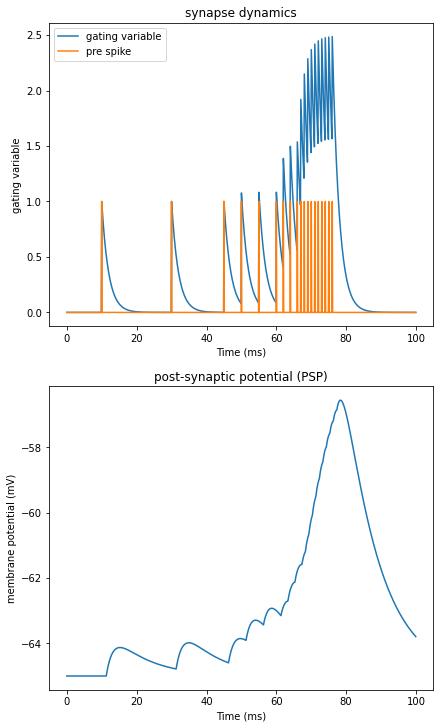

In [7]:
# get input current
spike_ts = [10, 30, 45, 50, 55, 60, 62, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
duration = 100
spike_I = bp.inputs.spike_current(spike_ts, bp.profile._dt, 1., duration=duration)

run_ampa_single(cls = AMPA1(), Iext = spike_I, duration = duration)

### AMPA2 simulation

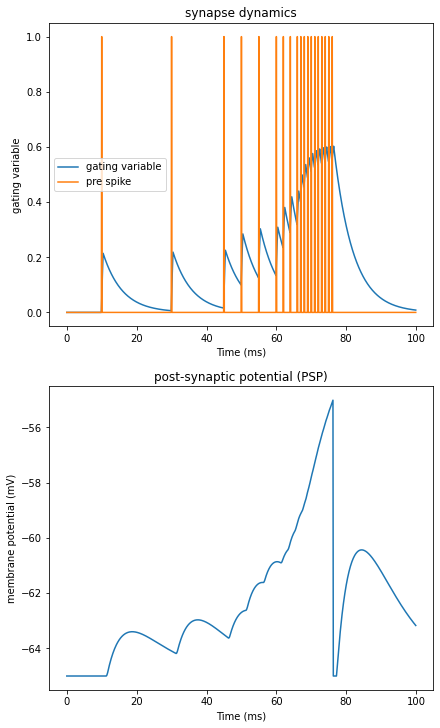

In [8]:
run_ampa_single(cls = AMPA2(), Iext = spike_I, duration = duration)

The graphs show similar dynamics of the gating variable between the two models. Since there is only one exponential decay of the AMPA1 model, it decays quickly after pre-synatical spikes. While the dynamic of AMPA2 model is modulated by two constants, it acts smoother.

### Stimulate pre-synaptic neuron

#### AMPA1

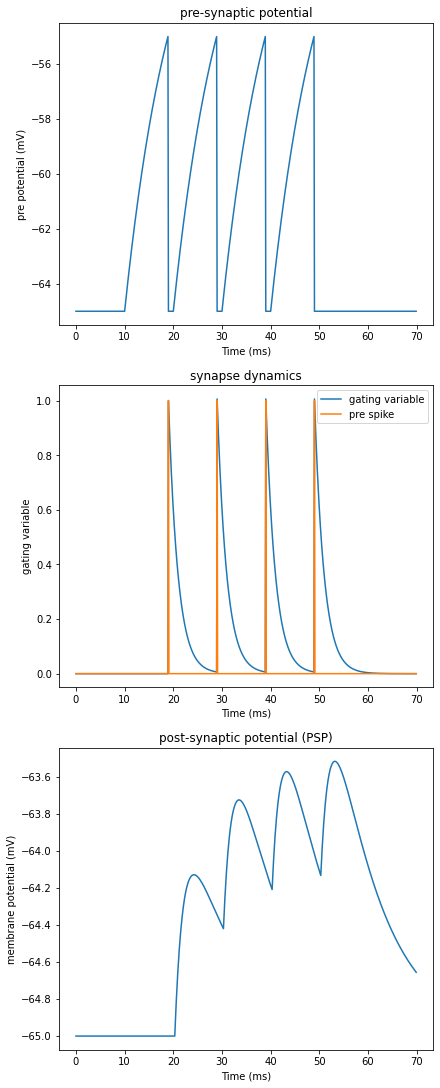

In [9]:
# step current parameters
amplitude = 16.9  # step current amplitude
stim_start = 10. # stimulation start point
stim_t = 40.   # stimulation duration
post_stim_t = 20. # after stimulation time

# generate step current
I = [(0, stim_start), (amplitude, stim_t), (0, post_stim_t)]
(step_I, duration) = bp.inputs.constant_current(I)

run_ampa_single(cls = AMPA1(), Iext = step_I, duration = duration, sim_pos = 'pre.inp')

#### AMPA2

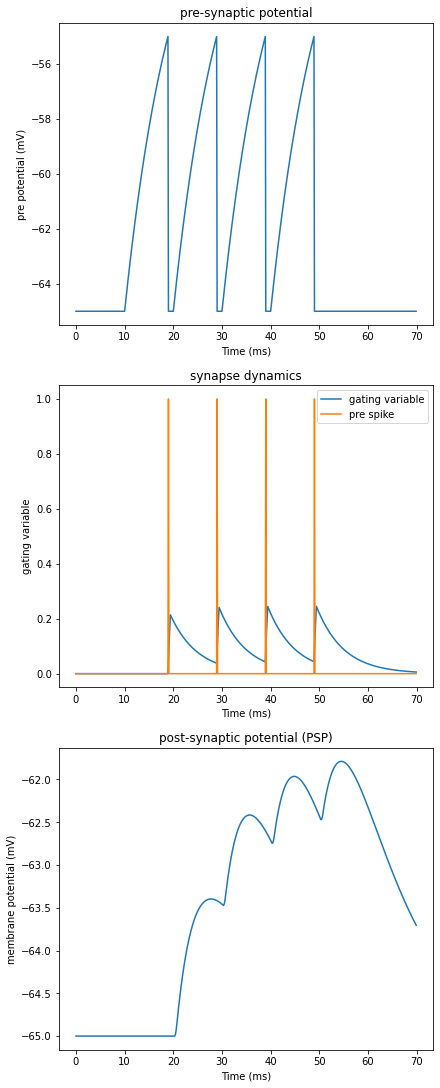

In [10]:
run_ampa_single(cls = AMPA2(), Iext = step_I, duration = duration, sim_pos = 'pre.inp')

## Implementation (vector)

Let's improve our codes to make it possible to run simulation of a group of synapse!

Again, we will implement the two kinds of models and compare there results.

$$ I_{syn}=\bar{g}_{syn} s (V-E_{syn}) $$

$$\frac{d s}{d t}=-\frac{s}{\tau_{decay}}+\sum_{k} \delta(t-t_{j}^{k}) $$

In [11]:
def AMPA1_batch(g_max=0.10, E=0., tau_decay=2.0):
    """AMPA conductance-based synapse (type 1).

    Parameters
    ----------
    g_max : float
        Maximum conductance.
    E : float
        Reversal potential.
    tau_decay : float
        Tau for decay.
    """

    @bp.integrate
    def ints(s, t):
        return - s / tau_decay

    # requirements
    # ------------

    requires = {
        'ST': bp.types.SynState(['s', 'g'], help='AMPA synapse state.'),
        'pre': bp.types.NeuState(['sp'], help='Pre-synaptic neuron state must have "sp" item.'),
        'post': bp.types.NeuState(['V', 'inp'], help='Pre-synaptic neuron state must have "V" and "inp" item.'),
        'pre2syn': bp.types.ListConn(help='Pre-synaptic neuron index -> synapse index'),
        'post2syn': bp.types.ListConn(help='Post-synaptic neuron index -> synapse index'),
    }

    # model logic
    # -----------

    # pre -> syn (transmitter releases: 0 and 1)
    def update(ST, _t_, pre, pre2syn):
        # exponential decay
        s = ints(ST['s'], _t_)

        # dynamics of transmitter-activated ion channels
        spike_idx = np.where(pre['sp'] > 0.)[0]
        for i in spike_idx:
            syn_idx = pre2syn[i]
            s[syn_idx] += 1.

        # update values
        ST['s'] = s
        ST['g'] = g_max * s

    # syn -> post (output current I_syn)
    @bp.delayed
    def output(ST, post, post2syn):
        post_cond = np.zeros(len(post2syn), dtype=np.float_)
        for post_id, syn_ids in enumerate(post2syn):
            post_cond[post_id] = np.sum(ST['g'][syn_ids])
        post['inp'] -= post_cond * (post['V'] - E)

    return bp.SynType(name='AMPA1',
                      requires=requires,
                      steps=(update, output),
                      vector_based=True)

In [12]:
def AMPA2_batch(g_max=0.42, E=0., alpha=0.98, beta=0.18, T=0.5, T_duration=0.5):
    """AMPA conductance-based synapse (type 2).

    Parameters
    ----------
    g_max : float
        Maximum conductance.
    E : float
        Reversal potential.
    alpha
    beta
    T
    T_duration
    """

    @bp.integrate
    def int_s(s, t, TT):
        return alpha * TT * (1 - s) - beta * s

    requires = dict(
        ST=bp.types.SynState({'s': 0., 'sp_t': -1e7, 'g': 0.},
                             help='AMPA synapse state.\n'
                                  '"s": Synaptic state.\n'
                                  '"sp_t": Pre-synaptic neuron spike time.'),
        pre=bp.types.NeuState(['sp'], help='Pre-synaptic neuron state must have "sp" item.'),
        post=bp.types.NeuState(['V', 'inp'], help='Pre-synaptic neuron state must have "V" and "inp" item.'),
        pre2syn=bp.types.ListConn(help='Pre-synaptic neuron index -> synapse index'),
        post2syn=bp.types.ListConn(help='Post-synaptic neuron index -> synapse index'),
    )

    def update(ST, _t_, pre, pre2syn):
        for i in np.where(pre['sp'] > 0.)[0]:
            syn_idx = pre2syn[i]
            ST['sp_t'][syn_idx] = _t_
        TT = ((_t_ - ST['sp_t']) < T_duration) * T
        s = np.clip(int_s(ST['s'], _t_, TT), 0., 1.)
        ST['s'] = s
        ST['g'] = g_max * s

    @bp.delayed
    def output(ST, post, post2syn):
        post_cond = np.zeros(len(post2syn), dtype=np.float_)
        for post_id, syn_ids in enumerate(post2syn):
            post_cond[post_id] = np.sum(ST['g'][syn_ids])
        post['inp'] -= post_cond * (post['V'] - E)

    return bp.SynType(name='AMPA',
                      requires=requires,
                      steps=(update, output),
                      vector_based=True)


### Simulation

In [13]:
def run_ampa_group(define, Iext, duration, sim_pos = 'pre.sp'):
    cls = define()
    LIF = define_LIF()
    pre = bp.NeuGroup(LIF, 1, monitors=['sp', 'V'])
    post = bp.NeuGroup(LIF, 1, monitors=['V'])
    ampa = bp.SynConn(model=cls, num = 1, pre_group=pre, post_group=post, 
                      conn=bp.connect.All2All(),
                      monitors=['s'], delay=1.)
    
    net = bp.Network(pre, ampa, post)
    net.run(duration, inputs=(ampa, sim_pos, Iext, '='), report=False)
    
    # visualization
    if sim_pos == 'pre.inp':
        n_plots = 3
    else:
        n_plots = 2
    
    fig, gs = bp.visualize.get_figure(n_plots, 1, 5, 6)
    
    ts = net.ts
    
    # synapse
    fig.add_subplot(gs[n_plots - 2, 0])
    plt.plot(ts, ampa.mon.s[:, 0], label='gating variable')
    plt.plot(ts, Iext, label='pre spike')
    plt.ylabel('gating variable')
    plt.xlabel('Time (ms)')
    plt.title('synapse dynamics')
    plt.legend()
    
    # PSP
    fig.add_subplot(gs[n_plots - 1, 0])
    plt.plot(ts, post.mon.V[:, 0])
    plt.ylabel('membrane potential (mV)')
    plt.xlabel('Time (ms)')
    plt.title('post-synaptic potential (PSP)')
    
    if n_plots == 3:
        # pre potential
        fig.add_subplot(gs[0, 0])
        plt.plot(ts, pre.mon.V[:, 0])
        plt.ylabel('pre potential (mV)')
        plt.xlabel('Time (ms)')
        plt.title('pre-synaptic potential')

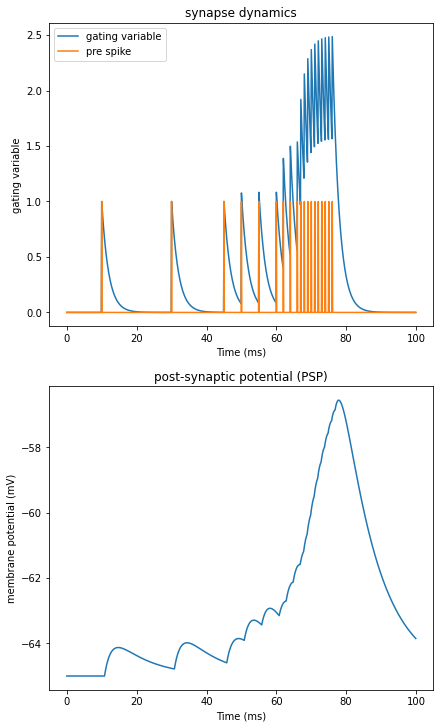

In [14]:
# get input current
spike_ts = [10, 30, 45, 50, 55, 60, 62, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
duration = 100
spike_I = bp.inputs.spike_current(spike_ts, bp.profile._dt, 1., duration=duration)

run_ampa_group(define = AMPA1_batch, Iext = spike_I, duration = duration)

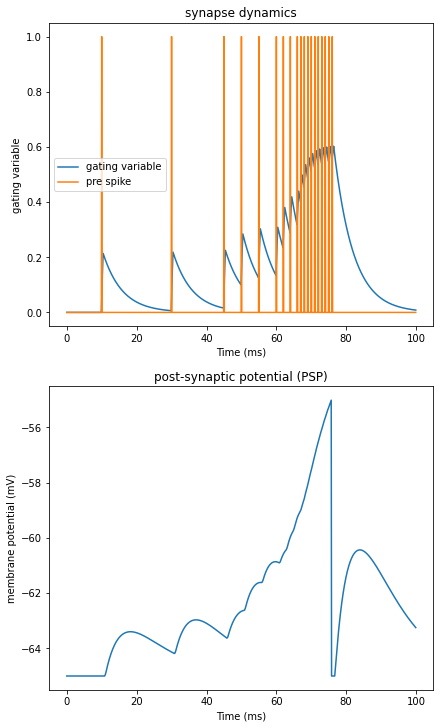

In [15]:
run_ampa_group(define = AMPA2_batch, Iext = spike_I, duration = duration)

# NMDA

## Model overview

NMDA receptor is other receptor of neurotransmitter `Glutamate`.

NMDA-receptor controlled channels exhibit a rich repertoire of dynamic behavior because their state is not only controlled by the presence or absence of glutamate, but also by the membrane potential. 

At resting potential, the NMDA channel is blocked by a common extracellular ion, ${\rm Mg}^{2+}$, even if glutamate is present. If the membrane is depolarized beyond −50 mV, the ${\rm Mg}^{2+}$-block is removed, the channel opens when glutamate binds to the receptor and, thereafter, stays open for 10 – 100 milliseconds.

A simple model of the voltage dependence of NMDA-receptor controlled channels is

$$ g(t) = \bar{g}_{syn} \cdot g_{\infty}  s $$

where

$$ g_{\infty}(V,[{Mg}^{2+}]_{o}) =(1+{e}^{-\alpha V} \cdot \frac{[{Mg}^{2+}]_{o} } {\beta})^{-1}  $$

Dynamics of $s$ is given by:

$$ \frac{d s_{j}(t)}{dt} =-\frac{s_{j}(t)}{\tau_{decay}}+a x_{j}(t)(1-s_{j}(t))  $$

$$ \frac{d x_{j}(t)}{dt} =-\frac{x_{j}(t)}{\tau_{rise}}+
\sum_{k} \delta(t-t_{j}^{k})  $$

where the decay time of NMDA currents is taken to be $\tau_{decay}=100 ms$,
$a= 0.5 ms^{-1}$, and$\tau_{rise} =2 ms$ (Hestrin et al., 1990; Spruston et al., 1995).

Again, the synaptic current is:

$$ I_{syn}= g(t) \cdot (V-E_{syn})$$

In [16]:
def NMDA(g_max=1.5, E=0, alpha=0.062, beta=3.57, cc_Mg=1.2, tau_decay=100., a=0.5, tau_rise=2.):
    """NMDA conductance-based synapse.

    Parameters
    ----------
    g_max : float
        The maximum conductance.
    E : float
        The reversal potential.
    alpha : float
    beta : float
    cc_Mg : float
    tau_decay : float
        The time constant of decay.
    tau_rise : float
        The time constant of rise.
    a : float
    """
    requires = dict(
        ST=bp.types.SynState(['x', 's']),
        pre=bp.types.NeuState(['sp']),
        post=bp.types.NeuState(['V', 'inp']),
        pre2syn=bp.types.ListConn(),
        post2syn=bp.types.ListConn(),
    )

    @bp.integrate
    def int_x(x, t):
        return -x / tau_rise

    @bp.integrate
    def int_s(s, t, x):
        return -s / tau_decay + a * x * (1 - s)

    def update(ST, _t_, pre):
        x = int_x(ST['x'], _t_)
        x += pre['sp']
        s = int_s(ST['s'], _t_, x)
        ST['x'] = x
        ST['s'] = s

    @bp.delayed
    def output(ST, post):
        g = g_max * ST['s'] * (post['V'] - E)
        g_inf = 1 + cc_Mg / beta * np.exp(-alpha * post['V'])
        post['inp'] -= g * g_inf

    return bp.SynType(name='NMDA',
                      requires=requires,
                      steps=(update, output),
                      vector_based=False)

## NMDA Visualization

In [17]:
def run_nmda_single(cls, Iext, duration, sim_pos = 'pre.sp'):
    '''
    Run single simulation with nmda synapse.

    Args:
        cls (SynType): model.
        Iext (NPArray): external current.
        duration (float): duration of the external current.
        sim_pos (string): position that is given the exernal current, default = 'pre.sp'.
    '''
    LIF = define_LIF()
    pre = bp.NeuGroup(LIF, 1, monitors=['sp', 'V'])
    post = bp.NeuGroup(LIF, 1, monitors=['V'])
    nmda = bp.SynConn(model=cls, pre_group=pre, post_group=post, conn=bp.connect.All2All(),
                      monitors=['s'], delay=1.)

    # set nmda behaviour
    nmda.runner.set_schedule(['input', 'update', 'output', 'monitor'])

    # build network connection (pre-> nmda-> post)
    net = bp.Network(pre, nmda, post)

    # run simulation
    net.run(duration, inputs=(nmda, sim_pos, Iext, '='), report=False)

    # visualization
    if sim_pos == 'pre.inp':
        n_plots = 3
    else:
        n_plots = 2

    fig, gs = bp.visualize.get_figure(n_plots, 1, 5, 6)

    ts = net.ts

    # synapse
    fig.add_subplot(gs[n_plots - 2, 0])
    plt.plot(ts, nmda.mon.s[:, 0], label='gating variable')
    if sim_pos == 'pre.inp':
        plt.plot(ts, pre.mon.sp[:, 0], label='pre spike')
    else:
        plt.plot(ts, Iext, label='pre spike')
    plt.ylabel('gating variable')
    plt.xlabel('Time (ms)')
    plt.title('synapse dynamics')
    plt.legend()
    
    # PSP
    fig.add_subplot(gs[n_plots - 1, 0])
    plt.plot(ts, post.mon.V[:, 0])
    plt.ylabel('membrane potential (mV)')
    plt.xlabel('Time (ms)')
    plt.title('post-synaptic potential (PSP)')

    if n_plots == 3:
        # pre potential
        fig.add_subplot(gs[0, 0])
        plt.plot(ts, pre.mon.V[:, 0])
        plt.ylabel('pre potential (mV)')
        plt.xlabel('Time (ms)')
        plt.title('pre-synaptic potential')

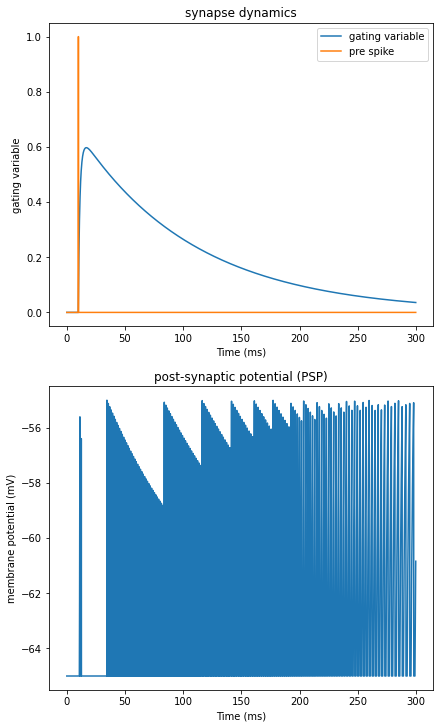

In [18]:
# get input current
spike_ts = [10]
duration = 300
spike_I = bp.inputs.spike_current(spike_ts, bp.profile._dt, 1., duration=duration)

run_nmda_single(cls = NMDA(), Iext = spike_I, duration = duration)

#### Pre-synaptic stimulation

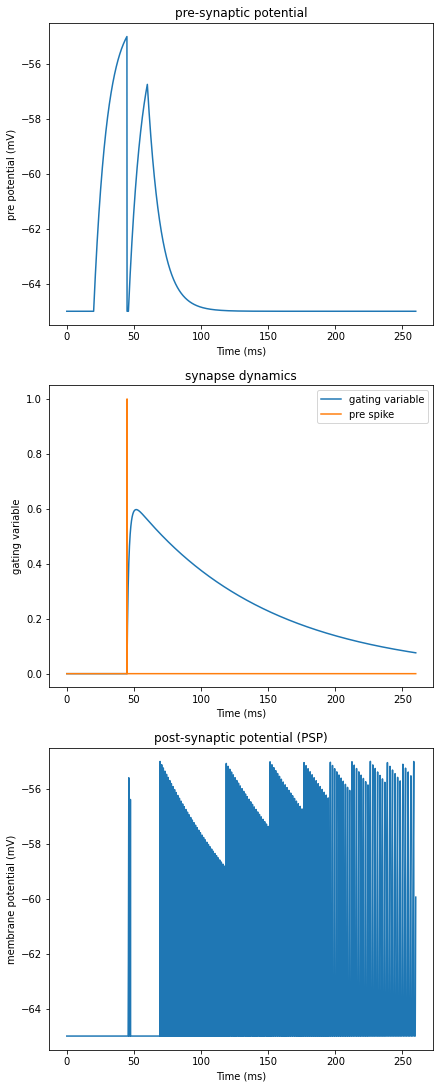

In [19]:
# step current parameters
amplitude = 10.9  # step current amplitude
stim_start = 20. # stimulation start point
stim_t = 40.   # stimulation duration
post_stim_t = 200. # after stimulation time

# generate step current
I = [(0, stim_start), (amplitude, stim_t), (0, post_stim_t)]
(step_I, duration) = bp.inputs.constant_current(I)

run_nmda_single(cls = NMDA(), Iext = step_I, duration = duration, sim_pos = 'pre.inp')

### NDMA vector

In [20]:
def NMDA_batch(g_max=0.15, E=0, alpha=0.062, beta=3.75, cc_Mg=1.2, tau_decay=100., a=0.5, tau_rise=2.):
    """NMDA conductance-based synapse.

    Parameters
    ----------
    g_max : float
        The maximum conductance.
    E : float
        The reversal potential.
    alpha : float
    beta : float
    cc_Mg : float
    tau_decay : float
        The time constant of decay.
    tau_rise : float
        The time constant of rise.
    a : float
    """
    requires = dict(
        ST=bp.types.SynState(['x', 's', 'g']),
        pre=bp.types.NeuState(['sp']),
        post=bp.types.NeuState(['V', 'inp']),
        pre2syn=bp.types.ListConn(),
        post2syn=bp.types.ListConn(),
    )

    @bp.integrate
    def int_x(x, t):
        return -x / tau_rise

    @bp.integrate
    def int_s(s, t, x):
        return -s / tau_decay + a * x * (1 - s)

    def update(ST, _t_, pre, pre2syn):
        for pre_id in np.where(pre['sp'] > 0.)[0]:
            syn_ids = pre2syn[pre_id]
            ST['x'][syn_ids] += 1.
        x = int_x(ST['x'], _t_)
        s = int_s(ST['s'], _t_, x)
        ST['x'] = x
        ST['s'] = s
        ST['g'] = g_max * s

    @bp.delayed
    def output(ST, post, post2syn):
        post_cond = np.zeros(len(post2syn), dtype=np.float_)
        for post_id, syn_ids in enumerate(post2syn):
            post_cond[post_id] = np.sum(ST['g'][syn_ids])
        g = post_cond * (post['V'] - E)
        g_inf = 1 + cc_Mg / beta * np.exp(-alpha * post['V'])
        post['inp'] -= g * g_inf

    return bp.SynType(name='NMDA',
                      requires=requires,
                      steps=(update, output),
                      vector_based=True)

In [21]:
def run_nmda_group(define, Iext, duration, sim_pos = 'pre.sp'):
    cls = define()
    LIF = define_LIF()
    pre = bp.NeuGroup(LIF, 1, monitors=['sp', 'V'])
    post = bp.NeuGroup(LIF, 1, monitors=['V'])
    nmda = bp.SynConn(model=cls, num = 1, pre_group=pre, post_group=post, 
                      conn=bp.connect.All2All(),
                      monitors=['s'], delay=1.)
    
    net = bp.Network(pre, nmda, post)
    net.run(duration, inputs=(nmda, sim_pos, Iext, '='), report=False)
    
    # visualization
    if sim_pos == 'pre.inp':
        n_plots = 3
    else:
        n_plots = 2
    
    fig, gs = bp.visualize.get_figure(n_plots, 1, 5, 6)
    
    ts = net.ts
    
    # synapse
    fig.add_subplot(gs[n_plots - 2, 0])
    plt.plot(ts, nmda.mon.s[:, 0], label='gating variable')
    plt.plot(ts, Iext, label='pre spike')
    plt.ylabel('gating variable')
    plt.xlabel('Time (ms)')
    plt.title('synapse dynamics')
    plt.legend()
    
    # PSP
    fig.add_subplot(gs[n_plots - 1, 0])
    plt.plot(ts, post.mon.V[:, 0])
    plt.ylabel('membrane potential (mV)')
    plt.xlabel('Time (ms)')
    plt.title('post-synaptic potential (PSP)')
    
    if n_plots == 3:
        # pre potential
        fig.add_subplot(gs[0, 0])
        plt.plot(ts, pre.mon.V[:, 0])
        plt.ylabel('pre potential (mV)')
        plt.xlabel('Time (ms)')
        plt.title('pre-synaptic potential')

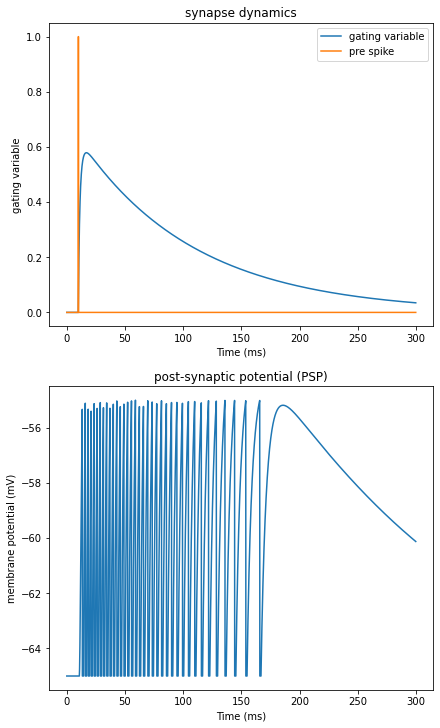

In [22]:
# get input current
spike_ts = [10]
duration = 300
spike_I = bp.inputs.spike_current(spike_ts, bp.profile._dt, 1., duration=duration)

run_nmda_group(define = NMDA_batch, Iext = spike_I, duration = duration)

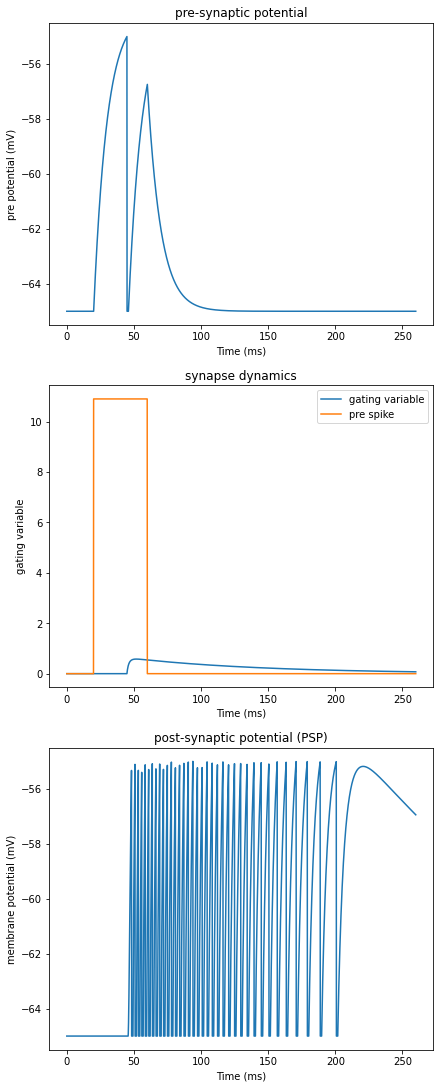

In [23]:
# step current parameters
amplitude = 10.9  # step current amplitude
stim_start = 20. # stimulation start point
stim_t = 40.   # stimulation duration
post_stim_t = 200. # after stimulation time

# generate step current
I = [(0, stim_start), (amplitude, stim_t), (0, post_stim_t)]
(step_I, duration) = bp.inputs.constant_current(I)

run_nmda_group(define = NMDA_batch, Iext = step_I, duration = duration, sim_pos = 'pre.inp')

### AMPA and NMDA

Let's see how the two receptors react after the coming of Glutamate.

In [24]:
def run_glu_single(nmda_model, ampa_model, Iext, duration, sim_pos = 'pre.sp'):
    '''
    Run single simulation with nmda synapse.

    Args:
        cls (SynType): model.
        Iext (NPArray): external current.
        duration (float): duration of the external current.
        sim_pos (string): position that is given the exernal current, default = 'pre.sp'.
    '''
    LIF = define_LIF()
    n_pre = bp.NeuGroup(LIF, 1, monitors=['sp', 'V'])
    n_post = bp.NeuGroup(LIF, 1, monitors=['V'])
    nmda = bp.SynConn(model=nmda_model, pre_group=n_pre, post_group=n_post, conn=bp.connect.All2All(),
                      monitors=['s'], delay=1.)
    
    a_pre = bp.NeuGroup(LIF, 1, monitors=['sp', 'V'])
    a_post = bp.NeuGroup(LIF, 1, monitors=['V'])
    ampa = bp.SynConn(model=ampa_model, pre_group=a_pre, post_group=a_post, conn=bp.connect.All2All(),
                      monitors=['s'], delay=1.)

    # set synapse behaviour
    nmda.runner.set_schedule(['input', 'update', 'output', 'monitor'])
    ampa.runner.set_schedule(['input', 'update', 'output', 'monitor'])
    
    # build network connection
    net_nmda = bp.Network(n_pre, nmda, n_post)
    net_ampa = bp.Network(a_pre, ampa, a_post)

    # run simulation
    net_nmda.run(duration, inputs=(nmda, sim_pos, Iext, '='), report=False)
    net_ampa.run(duration, inputs=(ampa, sim_pos, Iext, '='), report=False)

    # visualization
    if sim_pos == 'pre.inp':
        n_plots = 3
    else:
        n_plots = 2

    fig, gs = bp.visualize.get_figure(n_plots, 1, 4, 9)

    ts = net_nmda.ts

    # synapse
    fig.add_subplot(gs[n_plots - 2, 0])
    plt.plot(ts, nmda.mon.s[:, 0], 'b', label='NMDA')
    plt.plot(ts, ampa.mon.s[:, 0], 'g', label='AMPA')
    if sim_pos == 'pre.inp':
        plt.plot(ts, n_pre.mon.sp[:, 0], 'r', label='pre spike')
        #plt.plot(ts, a_pre.mon.sp[:, 0], 'r', label='pre spike (AMPA)')
    else:
        pass
        #plt.plot(ts, Iext, 'r', label='pre spike')
    plt.ylabel('gating variable')
    plt.xlabel('Time (ms)')
    plt.title('synapse dynamics')
    plt.legend()
    
    '''
    # PSP
    fig.add_subplot(gs[n_plots - 1, 0])
    plt.plot(ts, n_post.mon.V[:, 0], 'b', label='NMDA')
    plt.plot(ts, a_post.mon.V[:, 0], 'g', label='AMPA')
    plt.ylabel('membrane potential (mV)')
    plt.xlabel('Time (ms)')
    plt.title('post-synaptic potential (PSP)')
    plt.legend()
    '''

    if n_plots == 3:
        # pre potential
        fig.add_subplot(gs[0, 0])
        plt.plot(ts, n_pre.mon.V[:, 0])
        plt.plot(ts, a_pre.mon.V[:, 0], 'b')
        plt.ylabel('pre potential (mV)')
        plt.xlabel('Time (ms)')
        plt.title('pre potential')

#### Single spike

Let's run simulation to see the dynamics of gating variables after a single pre-synaptic spike at $t=0$. 

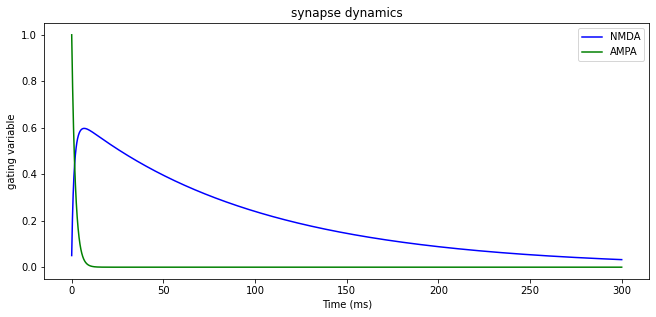

In [25]:
# get input current
spike_ts = [0]
duration = 300.
spike_I = bp.inputs.spike_current(spike_ts, bp.profile._dt, 1., duration=duration)

run_glu_single(nmda_model = NMDA(), ampa_model = AMPA1(), Iext = spike_I, duration = duration)

#### Pre-synaptic stimulation

Let's inject a step current to the pre-synaptic neuron and see the responses of the NMDA and AMPA synapses.

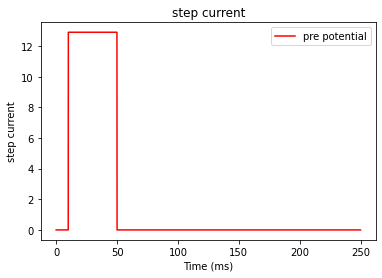

In [26]:
# step current parameters
amplitude = 12.9  # step current amplitude
stim_start = 10. # stimulation start point
stim_t = 40.   # stimulation duration
post_stim_t = 200. # after stimulation time

# generate step current
I = [(0, stim_start), (amplitude, stim_t), (0, post_stim_t)]
(step_I, duration) = bp.inputs.constant_current(I)

plt.plot(np.arange(len(step_I))/(len(step_I)/duration), step_I, 'r', label='pre potential')
plt.ylabel('step current')
plt.xlabel('Time (ms)')
plt.title('step current')
plt.legend()

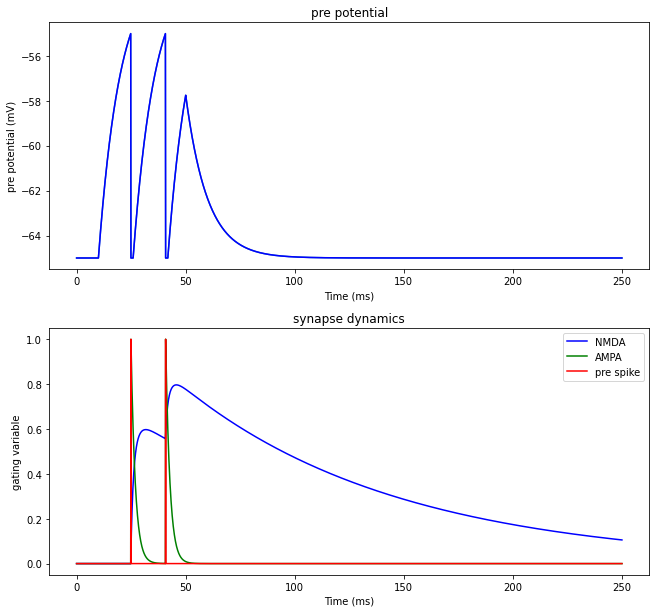

In [27]:
run_glu_single(nmda_model = NMDA(), ampa_model = AMPA1(), Iext = step_I, duration = duration, sim_pos = 'pre.inp')

Our simulation results correspond to the biological data that AMPA receptors decay rapidly and NMDA receptors often decay much slower. 